In [1]:
import pyodbc
import pandas as pd

driver= '{ODBC Driver 13 for SQL Server}'
cnxn = pyodbc.connect('DRIVER='+driver+';PORT=1433;SERVER='+server+';PORT=1443;DATABASE='+database+';UID='+username+';PWD='+ password)

In [2]:
test_df = pd.read_sql_query("SELECT * from dbo.orders where eval_set = 'train'",cnxn, coerce_float = False)

In [3]:
test_df.head(5)

order_id user_id eval_set order_number order_dow order_hour_of_day  \
0  1187899       1    train           11         4                08   
1  1492625       2    train           15         1                11   
2  2196797       5    train            5         0                11   
3   525192       7    train           21         2                11   
4   880375       8    train            4         1                14   

  days_since_prior_order  
0                   14.0  
1                   30.0  
2                    6.0  
3                    6.0  
4                   10.0

## Read Data (products, departments, aisles,orders and products per order)

In [4]:
products = pd.read_sql_query("SELECT * from dbo.products",cnxn, coerce_float = False)
dept = pd.read_sql_query("SELECT * from dbo.departments",cnxn, coerce_float = False)
aisles = pd.read_sql_query("SELECT * from dbo.aisles",cnxn, coerce_float = False)
orders_prod_t = pd.read_sql_query("SELECT * from dbo.order_products__train",cnxn, coerce_float = False)
orders_train = pd.read_sql_query("SELECT * from dbo.orders where eval_set = 'train'",cnxn, coerce_float = False)
cnxn.close()


In [5]:
#if reading from csv
#products=pd.read_csv("products.csv",index_col=None,header=0)
#dept=pd.read_csv("departments.csv",index_col=None,header=0)
#aisles=pd.read_csv("aisles.csv",index_col=None,header=0)
#orders_prod_t=pd.read_csv("order_products__train.csv",index_col=None,header=0)
#orders_train = pd.read_csv("orders_train.csv",index_col=None,header=0)

In [6]:
%matplotlib inline
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
from multiprocessing import Pool
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as ss
from akapriori import apriori
import networkx as nx
#import armine
#import networkx as nx
#import hashlib

%matplotlib inline
sns.set(style='ticks', palette='Set2')
plt.rcParams['figure.figsize'] = 10, 8


## Expore Data

In [7]:
aisles.head()

aisle_id                       aisle
0        1       prepared soups salads
1        2           specialty cheeses
2        3         energy granola bars
3        4               instant foods
4        5  marinades meat preparation

In [8]:
dept.head()

department_id department
0             1     frozen
1             2      other
2             3     bakery
3             4    produce
4             5    alcohol

In [9]:
products.head()

product_id                                       product_name aisle_id  \
0          1                         Chocolate Sandwich Cookies       61   
1          2                                   All-Seasons Salt      104   
2          3               Robust Golden Unsweetened Oolong Tea       94   
3          4  Smart Ones Classic Favorites Mini Rigatoni Wit...       38   
4          5                          Green Chile Anytime Sauce        5   

  department_id  
0            19  
1            13  
2             7  
3             1  
4            13

In [10]:
orders_prod_t.head()

order_id product_id add_to_cart_order reordered
0        1      49302                 1         1
1        1      11109                 2         1
2        1      10246                 3         0
3        1      49683                 4         0
4        1      43633                 5         1

In [11]:
orders_train.head()

order_id user_id eval_set order_number order_dow order_hour_of_day  \
0  1187899       1    train           11         4                08   
1  1492625       2    train           15         1                11   
2  2196797       5    train            5         0                11   
3   525192       7    train           21         2                11   
4   880375       8    train            4         1                14   

  days_since_prior_order  
0                   14.0  
1                   30.0  
2                    6.0  
3                    6.0  
4                   10.0

In [12]:
## Number of unique customers
len(orders_train.user_id.drop_duplicates())

131209

In [13]:
#Num of unique products
len(products.product_id.drop_duplicates())

49688

## Join all data into one dataframe

In [14]:
orders_prod_norm=orders_prod_t.merge(orders_train,on="order_id")


In [15]:
orders_prod_norm=orders_prod_norm.merge(products,on="product_id")

In [16]:
orders_prod_norm=orders_prod_norm.merge(aisles,on="aisle_id")

In [17]:
orders_prod_norm=orders_prod_norm.merge(dept,on="department_id")

In [18]:
orders_prod_norm.head(5)

order_id product_id add_to_cart_order reordered user_id eval_set  \
0        1      49302                 1         1  112108    train   
1   816049      49302                 7         1   47901    train   
2  1383349      49302                11         1   41425    train   
3  1242203      49302                 1         1    2993    train   
4  1787378      49302                 8         0  187205    train   

  order_number order_dow order_hour_of_day days_since_prior_order  \
0            4         4                10                    9.0   
1           14         4                06                   16.0   
2            4         3                08                   14.0   
3           15         0                07                    7.0   
4            5         4                14                   30.0   

       product_name aisle_id department_id   aisle  department  
0  Bulgarian Yogurt      120            16  yogurt  dairy eggs  
1  Bulgarian Yogurt      120            16  yogurt  dairy eggs  
2  Bulgarian Yogurt      120            16  yogurt  dairy eggs  
3  Bulgarian Yogurt      120            16  yogurt  dairy eggs  
4  Bulgarian Yogurt      120            16  yogurt  dairy eggs

## how many times each product was ordered - Bananas, Strawberries, Spinach

In [19]:
g=orders_prod_norm.product_id.value_counts()
g=pd.DataFrame(g)
g.reset_index(inplace=True)
g.columns = ["product_id","count"]
g_products=g.merge(products,on="product_id")
g_products.head()

product_id  count            product_name aisle_id department_id
0      24852  18726                  Banana       24             4
1      13176  15480  Bag of Organic Bananas       24             4
2      21137  10894    Organic Strawberries       24             4
3      21903   9784    Organic Baby Spinach      123             4
4      47626   8135             Large Lemon       24             4

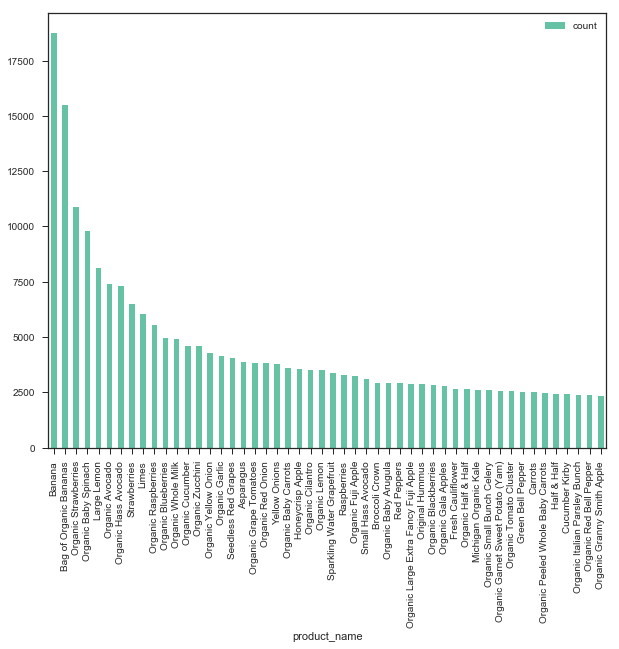

In [20]:
my_dpi=96
plt.figure(figsize=(50, 40), dpi=my_dpi)
plt.gcf().subplots_adjust(bottom=0.15)
g_products.head(50).plot(kind="bar",x="product_name",y="count")
#plt.savefig("chart1.png",my_dpi=1000,bbox_inches="tight" )

## Products orders Count Distribution

(0.99999999920974436, 34.390904383072481)


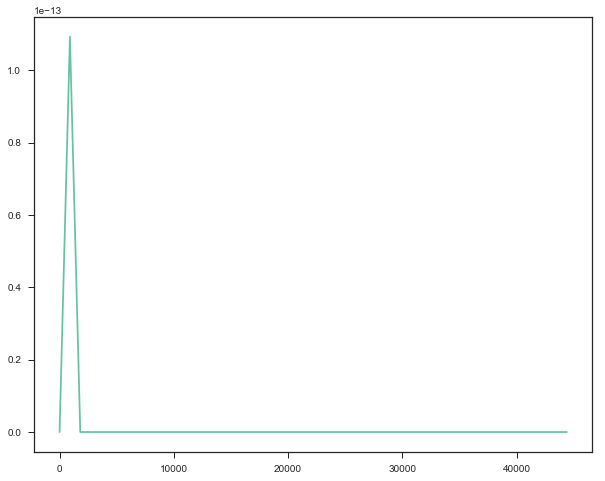

In [21]:
P=ss.expon.fit(g_products["count"])
print(P)
rX=np.linspace(0,44380)
rP =ss.expon.pdf(rX,*P)
plt.plot(rX,rP)

## Group by department (number of orders per department)

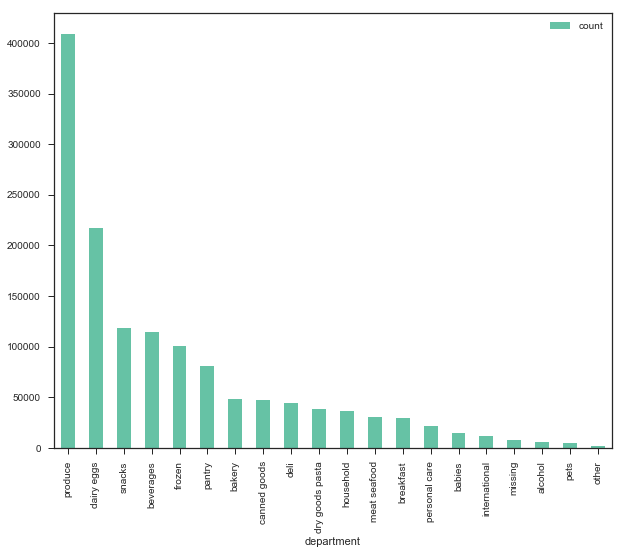

In [22]:
g=orders_prod_norm.department_id.value_counts()
g=pd.DataFrame(g)
g.reset_index(inplace=True)
g.columns = ["department_id","count"]
g_dept=g.merge(dept,on="department_id")
g_dept.head(5)

g_dept.head(20).plot(kind="bar",x="department",y="count")
plt.savefig("chart2.png",my_dpi=1000,bbox_inches="tight" )

## Group by aisles (number of orders per aisle)¶


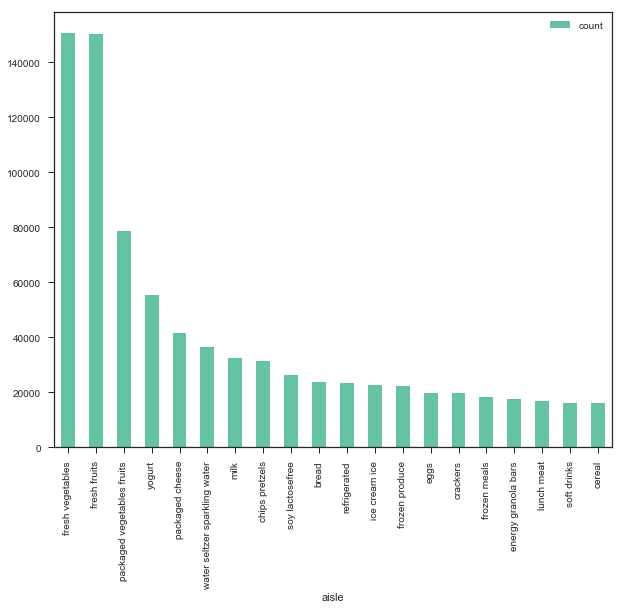

In [23]:
g=orders_prod_norm.aisle_id.value_counts()
g=pd.DataFrame(g)
g.reset_index(inplace=True)
g.columns = ["aisle_id","count"]
g_aisles=g.merge(aisles,on="aisle_id")
g_aisles.head()

g_aisles.head(20).plot(kind="bar",x="aisle",y="count")

## Market Basket Analysis¶


In [24]:
orders_prod_norm[["user_id","order_id","product_name","department","aisle"]].sort_values(by = "order_id").head(5)

user_id order_id                                   product_name  \
0       112108        1                               Bulgarian Yogurt   
68060   112108        1                    Organic Whole String Cheese   
626138  112108        1           Lightly Smoked Sardines in Olive Oil   
383140  112108        1                           Organic Hass Avocado   
55240   112108        1  Organic 4% Milk Fat Whole Milk Cottage Cheese   

          department                 aisle  
0         dairy eggs                yogurt  
68060     dairy eggs       packaged cheese  
626138  canned goods   canned meat seafood  
383140       produce          fresh fruits  
55240     dairy eggs  other creams cheeses

### Create a structure to run apriori

In [25]:
orders_prod_norm["product_id_str"]=orders_prod_norm["product_id"].astype(str)
g=orders_prod_norm.groupby("order_id")["product_name"]
g1=g.apply(lambda x: ','.join(x.str.replace(","," ")))
g2=pd.DataFrame(g1)
g2.reset_index(inplace=True)
g2["prod_list"]=g2.apply(lambda x: tuple(x["product_name"].split(",")),axis=1)
g2.head()


order_id                                       product_name  \
0        1  Bulgarian Yogurt,Organic 4% Milk Fat Whole Mil...   
1   100000  Total 2% All Natural Plain Greek Yogurt,Organi...   
2  1000008  Original No Pulp 100% Florida Orange Juice,DeT...   
3  1000029  Fresh Cauliflower,Broccoli Crown,Organic Red O...   
4   100003                       Organic Salted Butter,Cereal   

                                           prod_list  
0  (Bulgarian Yogurt, Organic 4% Milk Fat Whole M...  
1  (Total 2% All Natural Plain Greek Yogurt, Orga...  
2  (Original No Pulp 100% Florida Orange Juice, D...  
3  (Fresh Cauliflower, Broccoli Crown, Organic Re...  
4                    (Organic Salted Butter, Cereal)

### Generate Apriori associations

In [26]:
rules = apriori(list(g2["prod_list"]), support=0.008, confidence=0.1, lift=1.0)

In [27]:
# Sort rules
rules_sorted = sorted(rules, key=lambda x: (x[4], x[3], x[2]), reverse=True) # ORDER BY lift DESC, confidence DESC, support DESC

In [28]:
rules_sorted

[(frozenset({'Large Lemon'}),
  frozenset({'Limes'}),
  0.012156178310939037,
  0.19606637984019668,
  4.264159395400691),
 (frozenset({'Limes'}),
  frozenset({'Large Lemon'}),
  0.012156178310939037,
  0.264379247472236,
  4.26415939540069),
 (frozenset({'Organic Raspberries'}),
  frozenset({'Organic Strawberries'}),
  0.012727785441547455,
  0.3011179228272629,
  3.6267102566772844),
 (frozenset({'Organic Strawberries'}),
  frozenset({'Organic Raspberries'}),
  0.012727785441547455,
  0.15329539195887645,
  3.6267102566772844),
 (frozenset({'Organic Strawberries'}),
  frozenset({'Organic Blueberries'}),
  0.009671592649894444,
  0.11648613915917018,
  3.077734561606033),
 (frozenset({'Organic Blueberries'}),
  frozenset({'Organic Strawberries'}),
  0.009671592649894444,
  0.25553765606121626,
  3.0777345616060328),
 (frozenset({'Organic Avocado'}),
  frozenset({'Large Lemon'}),
  0.010281306922543422,
  0.18207585369145635,
  2.936692155747055),
 (frozenset({'Large Lemon'}),
  frozen

### Convert Rules into a dataframe

In [29]:
rules_list=[]
for r in rules_sorted:
    rules_list.append([list(r[0])[0],list(r[1])[0],r[2],r[3],r[4]])
    
df_rules=pd.DataFrame(rules_list)
df_rules.columns=["From","To","Support","Confidence","Lift"]

df_rules.head(20)

From                      To   Support  Confidence  \
0              Large Lemon                   Limes  0.012156    0.196066   
1                    Limes             Large Lemon  0.012156    0.264379   
2      Organic Raspberries    Organic Strawberries  0.012728    0.301118   
3     Organic Strawberries     Organic Raspberries  0.012728    0.153295   
4     Organic Strawberries     Organic Blueberries  0.009672    0.116486   
5      Organic Blueberries    Organic Strawberries  0.009672    0.255538   
6          Organic Avocado             Large Lemon  0.010281    0.182076   
7              Large Lemon         Organic Avocado  0.010281    0.165827   
8     Organic Hass Avocado  Bag of Organic Bananas  0.018444    0.331825   
9   Bag of Organic Bananas    Organic Hass Avocado  0.018444    0.156331   
10     Organic Raspberries  Bag of Organic Bananas  0.013566    0.320952   
11  Bag of Organic Bananas     Organic Raspberries  0.013566    0.114987   
12      Organic Fuji Apple                  Banana  0.009222    0.371508   
13           Organic Lemon  Bag of Organic Bananas  0.008132    0.304422   
14    Organic Strawberries    Organic Hass Avocado  0.011729    0.141270   
15    Organic Hass Avocado    Organic Strawberries  0.011729    0.211024   
16    Organic Baby Spinach         Organic Avocado  0.010685    0.143295   
17         Organic Avocado    Organic Baby Spinach  0.010685    0.189229   
18        Honeycrisp Apple                  Banana  0.009382    0.346663   
19    Organic Strawberries  Bag of Organic Bananas  0.023428    0.282174   

        Lift  
0   4.264159  
1   4.264159  
2   3.626710  
3   3.626710  
4   3.077735  
5   3.077735  
6   2.936692  
7   2.936692  
8   2.812560  
9   2.812560  
10  2.720400  
11  2.720400  
12  2.603072  
13  2.580293  
14  2.541609  
15  2.541609  
16  2.537673  
17  2.537673  
18  2.428991  
19  2.391714

### Create graph from rules

In [30]:
node_sizes = (df_rules['Support'] * 100000 * 2).astype(int)
#node_sizes

In [32]:
df_rules

From                      To   Support  Confidence  \
0              Large Lemon                   Limes  0.012156    0.196066   
1                    Limes             Large Lemon  0.012156    0.264379   
2      Organic Raspberries    Organic Strawberries  0.012728    0.301118   
3     Organic Strawberries     Organic Raspberries  0.012728    0.153295   
4     Organic Strawberries     Organic Blueberries  0.009672    0.116486   
5      Organic Blueberries    Organic Strawberries  0.009672    0.255538   
6          Organic Avocado             Large Lemon  0.010281    0.182076   
7              Large Lemon         Organic Avocado  0.010281    0.165827   
8     Organic Hass Avocado  Bag of Organic Bananas  0.018444    0.331825   
9   Bag of Organic Bananas    Organic Hass Avocado  0.018444    0.156331   
10     Organic Raspberries  Bag of Organic Bananas  0.013566    0.320952   
11  Bag of Organic Bananas     Organic Raspberries  0.013566    0.114987   
12      Organic Fuji Apple                  Banana  0.009222    0.371508   
13           Organic Lemon  Bag of Organic Bananas  0.008132    0.304422   
14    Organic Strawberries    Organic Hass Avocado  0.011729    0.141270   
15    Organic Hass Avocado    Organic Strawberries  0.011729    0.211024   
16    Organic Baby Spinach         Organic Avocado  0.010685    0.143295   
17         Organic Avocado    Organic Baby Spinach  0.010685    0.189229   
18        Honeycrisp Apple                  Banana  0.009382    0.346663   
19    Organic Strawberries  Bag of Organic Bananas  0.023428    0.282174   
20  Bag of Organic Bananas    Organic Strawberries  0.023428    0.198579   
21        Organic Cucumber  Bag of Organic Bananas  0.009664    0.274875   
22    Organic Hass Avocado    Organic Baby Spinach  0.009542    0.171671   
23    Organic Baby Spinach    Organic Hass Avocado  0.009542    0.127964   
24            Strawberries                  Banana  0.014847    0.299969   
25                  Banana            Strawberries  0.014847    0.104026   
26                  Banana         Organic Avocado  0.016889    0.118338   
27         Organic Avocado                  Banana  0.016889    0.299096   
28    Organic Baby Spinach             Large Lemon  0.009435    0.126533   
29             Large Lemon    Organic Baby Spinach  0.009435    0.152182   
30    Organic Baby Spinach    Organic Strawberries  0.012492    0.167518   
31    Organic Strawberries    Organic Baby Spinach  0.012492    0.150450   
32     Seedless Red Grapes                  Banana  0.008856    0.286277   
33           Yellow Onions                  Banana  0.008163    0.284689   
34     Organic Blueberries  Bag of Organic Bananas  0.008666    0.228957   
35    Organic Baby Spinach  Bag of Organic Bananas  0.017042    0.228536   
36  Bag of Organic Bananas    Organic Baby Spinach  0.017042    0.144444   
37      Organic Whole Milk  Bag of Organic Bananas  0.008521    0.227791   
38             Large Lemon                  Banana  0.016447    0.265274   
39                  Banana             Large Lemon  0.016447    0.115241   
40         Organic Avocado    Organic Strawberries  0.008292    0.146848   
41                   Limes                  Banana  0.010144    0.220620   
42                  Banana    Organic Baby Spinach  0.015243    0.106803   
43    Organic Baby Spinach                  Banana  0.015243    0.204415   
44    Organic Strawberries                  Banana  0.016569    0.199559   
45                  Banana    Organic Strawberries  0.016569    0.116095   
46         Organic Avocado  Bag of Organic Bananas  0.008155    0.144419   
47             Large Lemon  Bag of Organic Bananas  0.008056    0.129932   

        Lift  
0   4.264159  
1   4.264159  
2   3.626710  
3   3.626710  
4   3.077735  
5   3.077735  
6   2.936692  
7   2.936692  
8   2.812560  
9   2.812560  
10  2.720400  
11  2.720400  
12  2.603072  
13  2.580293  
14  2.541609  
15  2.541609  
16  2.537673  
17  2.537673  
18  2.428991

C:\Users\hvill\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\hvill\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\hvill\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\hvill\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

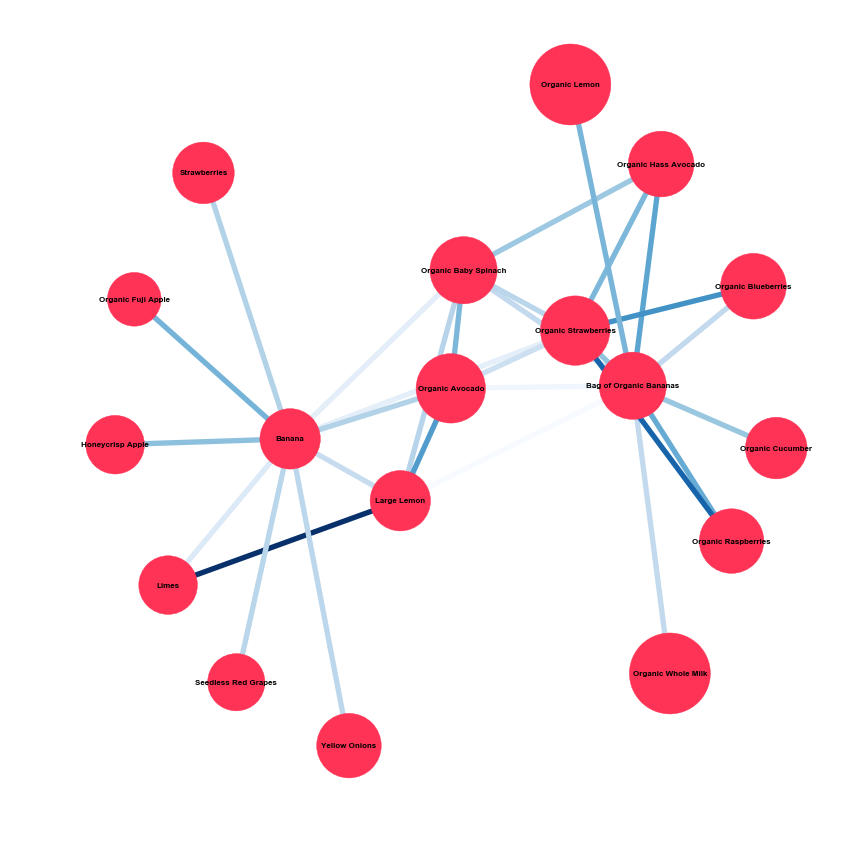

In [31]:
import networkx as nx
G=nx.from_pandas_dataframe(df_rules,"From","To","Lift")

my_dpi=96
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi,facecolor="lightslategray")

plt.facecolor="Black"
edges = G.edges()
colors = [G[u][v]['Lift'] for u,v in edges]
nx.draw(G,with_labels=True,node_color="#ff3355",node_size=node_sizes,
        edge_color=colors, arrows=False,font_color="Black",font_weight="bold",
        font_size=6,style="solid",width=4,edge_cmap=plt.cm.Blues)



plt.savefig("nx.png",format="png" )
plt.show()


In [ ]:
df_rules[df_rules['From'] =='eggs']